In [1]:
import numpy as np
import scipy.linalg as splin
from scipy.integrate import LSODA, solve_ivp
import matplotlib.pyplot as plt

from consts import *
from lyapunov import *
from pac import *
from potential import *
from lyap_obj import *

In [2]:
# Initial conditions (alpha0) and Jacobi interval
alpha0 = 50/384400 # initial guess for alpha

# C = 2U(r) - (vx^2 + vy^2)
C_range = [3.1370, 3.1493]

In [3]:
fL1 = Family(XL1, mu)
fL1.find_family(alpha0, 40)

In [4]:
fL2 = Family(XL2, mu)
fL2.find_family(alpha0, 40)

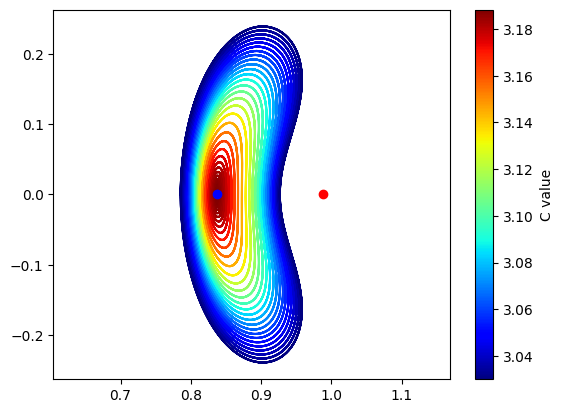

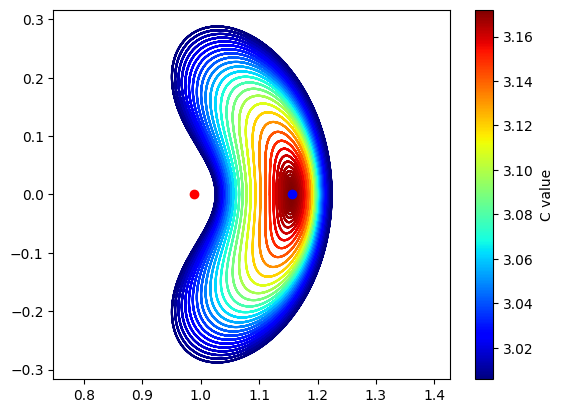

In [5]:
#fL1.plot_family()
#fL2.plot_family()

In [6]:
# Obtain two orbits in [C_range[0]  C_range[1]] in L1
orbsL1 = find_Crange(fL1, 2, C_range, verbose=True)

Found 1 orbits in the range, PACing to find more
Found orbit 1
ds: 0.01, C_guess: 3.1422696744783893, G_guess: 5.476330919737421e-13


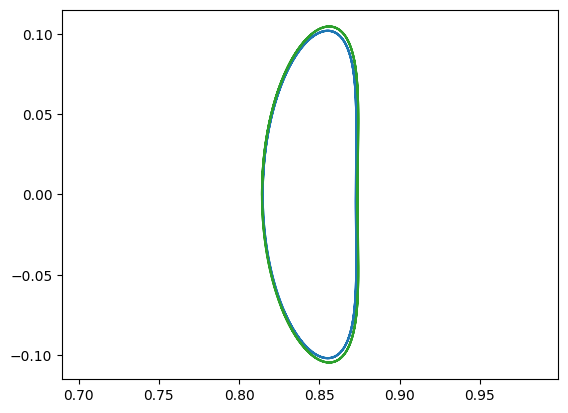

In [7]:
for orbit in orbsL1:
    orbit.plot()
plt.axis('equal')
plt.show()

In [8]:
# Find isoenergetic L2 orbits
isoC_L2 = []
for oL1 in orbsL1:
    isoC_L2.append(find_isoC(oL1, fL2, verbose=True)) 

Finding orbits with C = 3.1443992162204353
Orbit not in the C tolerance. C = 3.1433196599646114, err = 0.0010795562558238991, ds = 0.031947999937062266, G = 8.331699617969406e-13
Orbit not in the C tolerance. C = 3.1493193248151883, err = 0.004920108594753003, ds = -0.02904363630642024, G = 7.875477799008922e-13
Orbit not in the C tolerance. C = 3.143834479639619, err = 0.0005647365808161275, ds = 0.026403305733109308, G = 9.328671161431607e-13
Orbit not in the C tolerance. C = 3.1487985219467762, err = 0.004399305726340952, ds = -0.02400300521191755, G = 9.897267102174298e-13
Orbit not in the C tolerance. C = 3.1442650029547394, err = 0.00013421326569584835, ds = 0.021820913829015954, G = 7.902185644224434e-13
Orbit not in the C tolerance. C = 3.1483709929316586, err = 0.003971776711223285, ds = -0.019837194390014502, G = 8.209064130835645e-13
Orbit not in the C tolerance. C = 3.144624193000467, err = 0.00022497678003174926, ds = 0.018033813081831364, G = 8.91800706304798e-13
Orbit no

In [9]:
print(orbsL1[0].Yd)

[[0.81471266]
 [0.22150514]
 [2.87071409]]


In [ ]:
# out_folder = 'out/'
# for i in range(len(isoC_L2)):
#     orbsL1[i].save(out_folder + 'L1_' + str(i) + '.npz')
#     isoC_L2[i].save(out_folder + 'L2_' + str(i) + '.npz')
    

In [ ]:
# Take a pair of isoenergetic orbits and propagate them for a period T.
# Then, take a point in the interval and compute the eigenvectors and eigenvalues
# of the STM on that point.

# Once this is done, we have Es, Eu, Ec1, Ec2
#### STABLE MANIFOLD
# Inizialize an orbit in x = p +- de*Es/|Es| and propagate backwards for a period T 

#### UNSTABLE MANIFOLD
# Inizialize an orbit in x = p +- de*Eu/|Eu| and propagate forward for a period


In [16]:
# Integrate 
Yd0 = orbsL1[0].Yd
T0 = Yd0[0]

x0 = np.array([Yd0[0][0], 0, 0 , Yd0[1][0]])
PHI0 = np.eye(4)
X0 = np.concatenate((x0, PHI0.flatten()))

sol = solve_ivp(fdyn, [0, T0], X0,args=(T0, mu), method='LSODA', rtol=1e-12, atol=1e-12)

X = sol.y[:4,:]
PHI = sol.y[4:,:].reshape(4,4, -1)

# Compute the eigenvectors and eigenvalues of the STM at the final point
PHI_t = PHI[:,:,-1]
eigval, eigvec = splin.eig(PHI_t)
print(eigval)

# Print the absolute value of the eigenvalues
print(np.abs(eigval))




[4.59642932+0.j         0.21756018+0.j         0.34616477+0.93817373j
 0.34616477-0.93817373j]
[4.59642932 0.21756018 1.         1.        ]


In [10]:

# Compute states of the orbits
pair = 0 # pair of orbits to use

# Compute the states of the orbits
# L1
X1, PHI1 = orbsL1[pair].propagate()
# L2
X2, PHI2 = isoC_L2[pair].propagate()

T = orbsL1[pair].Yd[2]
# Take one point in X1
p_idx = 200 # index of the point, 0 <= p_idx < len(X1)
p = X1[:4, p_idx]
PHI1_p = PHI1[:, p_idx]
PHI1_p = PHI1_p.reshape((4, 4)) 

# Compute the eigenvectors and eigenvalues of the STM at p
eigvals, eigvecs = splin.eig(PHI1_p)
print(f"Eigenvalues: {eigvals}")
print(f"Det PHI1_p: {splin.det(PHI1_p)}")


Eigenvalues: [ 9.93570566e+01+0.j  1.00647104e-02+0.j -8.39478591e-01+0.j
 -1.19121561e+00+0.j]
Det PHI1_p: 1.0000000000006084


In [ ]:

# Compute the stable and unstable eigenvectors
Es_idx = [i for i in range(len(eigvals)) if np.abs(eigvals[i]) < 1 and eigvals[i].imag == 0]
Eu_idx = [i for i in range(len(eigvals)) if np.abs(eigvals[i]) > 1 and eigvals[i].imag == 0]

# Take eigenvalues and eigenvectors(only position components)
Es, EVs = eigvals[Es_idx], eigvecs[:, Es_idx]
Eu, EVu = eigvals[Eu_idx], eigvecs[:, Eu_idx]

print(f"Es: {Es}")
print(f"EVs: {EVs}")
print(f"Eu: {Eu}")
print(f"EVu: {EVu}")


In [ ]:
# Now that we have the stable and unstable eigenvecs, we can compute the deviation
# from the initial point p
de = 40/384400
xs_p = p + de*EVs[:, 0]/np.linalg.norm(EVs[:, 0])
xs_m = p - de*EVs[:, 0]/np.linalg.norm(EVs[:, 0])
# Strip the imaginary part
xs_p = np.real(xs_p)
xs_m = np.real(xs_m)

# Build state vector 
# xs_p = np.concatenate((xs_p, np.zeros(2)))
# xs_m = np.concatenate((xs_m, np.zeros(2)))

# Add the STM to the state vector
PHI0 = np.eye(4)

Xs_p = np.concatenate((xs_p, PHI0.flatten()))
Xs_m = np.concatenate((xs_m, PHI0.flatten()))

# Propagate the state vectors
sols_p = solve_ivp(fdyn, [T, 0], Xs_p, args = (T,mu), method='LSODA', rtol=1e-12, atol=1e-12)
sols_m = solve_ivp(fdyn, [T, 0], Xs_m, args = (T,mu), method='LSODA', rtol=1e-12, atol=1e-12)


In [ ]:
trak_p = sols_p.y[:2, :]
trak_m = sols_m.y[:2, :]
plt.plot(trak_p[0, :], trak_p[1, :], 'b')
plt.plot(trak_m[0, :], trak_m[1, :], 'r')

plt.plot(XL1[0], XL1[1], 'ro')
plt.plot(1-mu, 0, 'bo') 
plt.plot(-mu, 0, 'bo')
plt.axis('equal')
plt.show()

In [ ]:
xu_p = p + de*EVu[:, 0]/np.linalg.norm(EVu[:2, 0])
xu_m = p - de*EVu[:, 0]/np.linalg.norm(EVu[:2, 0])

# Strip the imaginary part
xu_p = np.real(xu_p)
xu_m = np.real(xu_m)

# xu_p = np.concatenate((xu_p, np.zeros(2)))
# xu_m = np.concatenate((xu_m, np.zeros(2)))



# Add the STM to the state vector
PHI0 = np.eye(4)

Xu_p = np.concatenate((xu_p, PHI0.flatten()))
Xu_m = np.concatenate((xu_m, PHI0.flatten()))

# Propagate the state vectors
solu_p = solve_ivp(fdyn, [T, 0], Xu_p, args = (T,mu), method='LSODA', rtol=1e-12, atol=1e-12)
solu_m = solve_ivp(fdyn, [T, 0], Xu_m, args = (T,mu), method='LSODA', rtol=1e-12, atol=1e-12)

In [ ]:
trau_p = solu_p.y[:2, :]
trau_m = solu_m.y[:2, :]
plt.plot(trau_p[0, :], trau_p[1, :], 'r')
plt.plot(trau_m[0, :], trau_m[1, :], 'b')

plt.plot(XL1[0], XL1[1], 'ro')
plt.plot(1-mu, 0, 'bo')
plt.plot(-mu, 0, 'bo')
plt.axis('equal')
plt.show()